In [1]:
!pip install --quiet efficientnet

from sklearn.model_selection import train_test_split
from kaggle_datasets import KaggleDatasets
from functools import partial
from efficientnet.keras import EfficientNetB4
from keras.initializers import TruncatedNormal
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import models, Model
from keras import layers, Input
import keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os, re, math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import cv2
import re
import math

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout,\
        Flatten,GlobalAveragePooling2D,BatchNormalization, Activation

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers

import tensorflow.keras.layers as L
import tensorflow.keras.backend as K


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install /kaggle/input/keras-pretrained-imagenet-weights/image_classifiers-1.0.0-py3-none-any.whl

Processing /kaggle/input/keras-pretrained-imagenet-weights/image_classifiers-1.0.0-py3-none-any.whl
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from classification_models.tfkeras import Classifiers

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470
Number of replicas: 8


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path('cassava-leaf-disease-classification')
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512]
CLASSES = ['0', '1', '2', '3', '4']

In [6]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


def read_tfrecord(example):
    tfrecord_format = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.int64)}
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.int64)
    return image, label


def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(partial(read_tfrecord), num_parallel_calls=AUTOTUNE)
    return dataset


def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    
    # Most of the augmentations and transforms from here:
    # https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = 512
    XDIM = DIM%2 #fix for size 331
    
    if 0.5 > tf.random.uniform([1], minval = 0, maxval = 1):
        rot = 15. * tf.random.normal([1],dtype='float32')
    else:
        rot = 180. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]), label


def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.7, 1.3)
    image = tf.image.random_brightness(image, 0.1)
    return image, label


def get_training_dataset(filenames):
    dataset = load_dataset(filenames, labeled=True)  
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE) 
    dataset = dataset.map(transform, num_parallel_calls = AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


def get_validation_dataset(filenames, ordered=False):
    dataset = load_dataset(filenames, labeled=True, ordered=ordered) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [7]:
checkpoint = ModelCheckpoint('best.h5', 
                monitor= 'val_loss', 
                verbose=1, 
                save_best_only=True, 
                mode= 'min', 
                save_weights_only = False) 

In [14]:
lr_scheduler = ExponentialDecay(
    initial_learning_rate=3e-4, 
    decay_steps=10000, 
    decay_rate=0.9)
T_1 = 0.2
T_2 = 1.2
SMOOTH_FRACTION = 0.05
N_ITER = 5


def get_model():
    with strategy.scope():
        
        def create_model(input_dim, base_model):
            inp = L.Input(input_dim)

            curr_output   = base_model(inp)
            curr_output_1 = L.GlobalAveragePooling2D()(curr_output)
            curr_output_2 = L.GlobalMaxPooling2D()(curr_output)
            curr_output   = L.concatenate([curr_output_1, curr_output_2])

            curr_output   = L.BatchNormalization()(curr_output)
            curr_output   = L.Dense(512, activation='elu')(curr_output)
            curr_output   = L.Dropout(0.5)(curr_output)
            curr_output   = L.BatchNormalization()(curr_output)
            curr_output   = L.Dense(256, activation='elu')(curr_output)
            curr_output   = L.Dropout(0.5)(curr_output)

            out = L.Dense(5, activation='softmax') (curr_output)
            model = Model(inp, out)
            return model
        
        class_wg_root = '/kaggle/input/keras-pretrained-imagenet-weights/'
    
        # backbone: 
        SeResNeXT50, preprocess_input = Classifiers.get('seresnext50')
        base_model = SeResNeXT50(input_shape=[*IMAGE_SIZE, 3], include_top=False,
                                 weights='imagenet',
                                pooling='avg')
#         base_model.load_weights(class_wg_root + 'seresnext50_imagenet_1000_no_top.h5')
        
    
#         base_model = EfficientNetB4(
#             include_top=False,
#             input_shape=[*IMAGE_SIZE, 3],
#             weights='noisy-student',
#             pooling='avg')
        
#         inputs = Input(shape=(*IMAGE_SIZE, 3))
#         x = base_model(inputs)
#         outputs = layers.Dense(5, activation='softmax')(x)

#         model = Model(inputs, outputs)

        model = create_model(input_dim=(*IMAGE_SIZE, 3), base_model = base_model)
        
        model.compile(
            optimizer = Adam(learning_rate=1e-4),
            loss = 'sparse_categorical_crossentropy',  
            metrics = ['sparse_categorical_accuracy']) 
        
        return model

In [15]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(os.path.join(GCS_PATH, 'train_tfrecords/ld_train*.tfrec')),
    test_size=0.25, random_state=42)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

train_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_validation_dataset(VALID_FILENAMES)

# patience = 5
# callbacks = [EarlyStopping(monitor='val_sparse_categorical_accuracy',
#                            patience=patience, restore_best_weights=True)]

In [18]:
model = get_model()

In [19]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Functional)            (None, 16, 16, 2048) 25579120    input_3[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_49 (Gl (None, 2048)         0           model_4[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 2048)         0           model_4[0][0]                    
____________________________________________________________________________________________

In [20]:
history = model.fit(train_dataset, 
    steps_per_epoch=STEPS_PER_EPOCH, 
    epochs=10,
    validation_data=val_dataset,
    validation_steps=VALID_STEPS,
    callbacks = [checkpoint])


Epoch 1/10
125/125 [==============================] - 608s 2s/step - loss: 1.5690 - sparse_categorical_accuracy: 0.5108 - val_loss: 0.6339 - val_sparse_categorical_accuracy: 0.8203

Epoch 00001: val_loss improved from inf to 0.63388, saving model to best.h5
Epoch 2/10
125/125 [==============================] - 226s 2s/step - loss: 0.7633 - sparse_categorical_accuracy: 0.7726 - val_loss: 0.4826 - val_sparse_categorical_accuracy: 0.8548

Epoch 00002: val_loss improved from 0.63388 to 0.48257, saving model to best.h5
Epoch 3/10
125/125 [==============================] - 223s 2s/step - loss: 0.6556 - sparse_categorical_accuracy: 0.8006 - val_loss: 0.4189 - val_sparse_categorical_accuracy: 0.8777

Epoch 00003: val_loss improved from 0.48257 to 0.41888, saving model to best.h5
Epoch 4/10
125/125 [==============================] - 224s 2s/step - loss: 0.5895 - sparse_categorical_accuracy: 0.8197 - val_loss: 0.4358 - val_sparse_categorical_accuracy: 0.8710

Epoch 00004: val_loss did not improv

In [23]:
model.save('seresnext50.h5')

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


<AxesSubplot:>

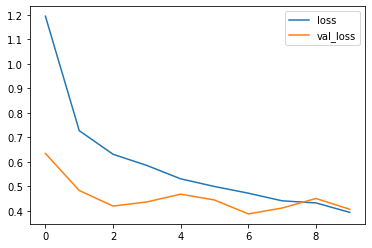

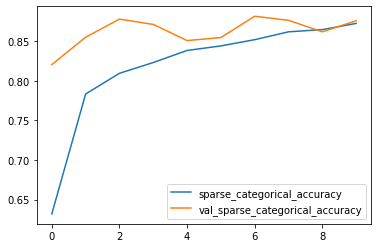

In [22]:
print(history.history.keys())

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()